# Aproksymacja funkcji za pomocą sieci neuronowej

Zadanie: Aproksymacja funkcji $f(x,y) = (x + 3y)^{-1/4}$ dla $x \in [1, 10]$, $y \in [1, 10]$

## Import bibliotek

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Definicja funkcji docelowej

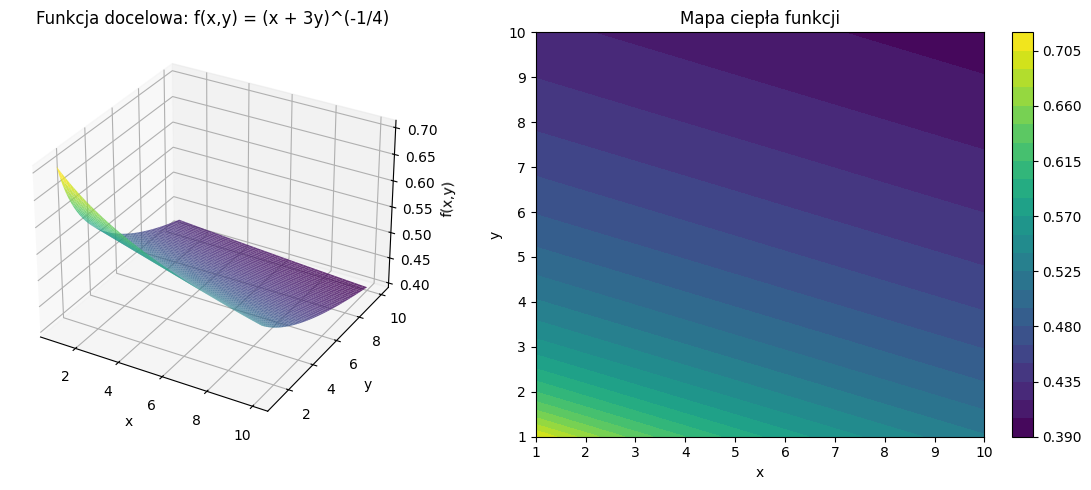

In [2]:
def target_function(x, y):
    """Funkcja docelowa: f(x,y) = (x + 3y)^(-1/4)"""
    return (x + 3*y)**(-0.25)

# wizualizacja funkcji
x_range = np.linspace(1, 10, 50)
y_range = np.linspace(1, 10, 50)
X, Y = np.meshgrid(x_range, y_range)
Z = target_function(X, Y)

fig = plt.figure(figsize=(12, 5))

# wykres 3D
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('f(x,y)')
ax1.set_title('Funkcja docelowa: f(x,y) = (x + 3y)^(-1/4)')

# mapa ciepła
ax2 = fig.add_subplot(122)
contour = ax2.contourf(X, Y, Z, levels=20, cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Mapa ciepła funkcji')
plt.colorbar(contour, ax=ax2)

plt.tight_layout()
plt.show()

## Funkcje aktywacji

In [3]:
def sigmoid(x):
    """Funkcja sigmoid"""
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """Pochodna funkcji sigmoid"""
    return sigmoid(x) * (1 - sigmoid(x))

def elu(x, alpha=1.0):
    """Funkcja ELU (Exponential Linear Unit)"""
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def elu_derivative(x, alpha=1.0):
    """Pochodna funkcji ELU"""
    return np.where(x > 0, 1, alpha * np.exp(x))

## Architektura sieci neuronowej

```python
nn_architecture = [
    {"input_dim": 2, "output_dim": 2, "activation": "elu"},
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"}
]
```

In [4]:
nn_architecture = [
    {"input_dim": 2, "output_dim": 2, "activation": "elu"},
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"}
]

## Inicjalizacja wag i biasów

In [5]:
def init_parameters(nn_architecture, seed=42):
    """Inicjalizacja wag i biasów"""
    np.random.seed(seed)
    params = {}
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        input_dim = layer["input_dim"]
        output_dim = layer["output_dim"]
        
        # inicjalizacja He dla warstw z ReLU/ELU
        params[f'W{layer_idx}'] = np.random.randn(output_dim, input_dim) * np.sqrt(2. / input_dim)
        params[f'b{layer_idx}'] = np.zeros((output_dim, 1))
    
    return params

## Forward propagation

In [6]:
def single_layer_forward(A_prev, W, b, activation):
    """Forward propagation dla pojedynczej warstwy"""
    Z = np.dot(W, A_prev) + b
    
    if activation == "sigmoid":
        A = sigmoid(Z)
    elif activation == "elu":
        A = elu(Z)
    else:
        raise ValueError(f"Nieznana funkcja aktywacji: {activation}")
    
    return A, Z

def full_forward(X, params, nn_architecture):
    """Forward propagation dla całej sieci"""
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        W_curr = params[f'W{layer_idx}']
        b_curr = params[f'b{layer_idx}']
        activation = layer["activation"]
        
        A_curr, Z_curr = single_layer_forward(A_prev, W_curr, b_curr, activation)
        
        memory[f'A{idx}'] = A_prev
        memory[f'Z{layer_idx}'] = Z_curr
    
    return A_curr, memory

## Funkcja kosztu

In [7]:
def compute_cost(Y_pred, Y_true):
    """Obliczenie funkcji kosztu (MSE)"""
    m = Y_true.shape[1]
    cost = np.sum((Y_pred - Y_true)**2) / (2 * m)
    return cost

## Backward propagation

In [8]:
def single_layer_backward(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation):
    """Backward propagation dla pojedynczej warstwy"""
    m = A_prev.shape[1]
    
    if activation == "sigmoid":
        dZ_curr = dA_curr * sigmoid_derivative(Z_curr)
    elif activation == "elu":
        dZ_curr = dA_curr * elu_derivative(Z_curr)
    else:
        raise ValueError(f"Nieznana funkcja aktywacji: {activation}")
    
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)
    
    return dA_prev, dW_curr, db_curr

def full_backward(Y_pred, Y_true, memory, params, nn_architecture):
    """Backward propagation dla całej sieci"""
    grads = {}
    m = Y_true.shape[1]
    Y_true = Y_true.reshape(Y_pred.shape)
    
    # gradient dla ostatniej warstwy (MSE)
    dA_prev = (Y_pred - Y_true)
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activation = layer["activation"]
        
        dA_curr = dA_prev
        A_prev = memory[f'A{layer_idx_prev}']
        Z_curr = memory[f'Z{layer_idx_curr}']
        W_curr = params[f'W{layer_idx_curr}']
        b_curr = params[f'b{layer_idx_curr}']
        
        dA_prev, dW_curr, db_curr = single_layer_backward(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activation
        )
        
        grads[f'dW{layer_idx_curr}'] = dW_curr
        grads[f'db{layer_idx_curr}'] = db_curr
    
    return grads

## Aktualizacja wag

In [9]:
def update_parameters(params, grads, nn_architecture, learning_rate):
    """Aktualizacja parametrów sieci"""
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        params[f'W{layer_idx}'] -= learning_rate * grads[f'dW{layer_idx}']
        params[f'b{layer_idx}'] -= learning_rate * grads[f'db{layer_idx}']
    
    return params

## Główna funkcja treningu

In [10]:
def train_network(X, Y, nn_architecture, epochs=10000, learning_rate=0.01):
    """Trening sieci neuronowej"""
    params = init_parameters(nn_architecture)
    cost_history = []
    
    for i in range(epochs):
        # forward propagation
        Y_pred, memory = full_forward(X, params, nn_architecture)
        
        # obliczenie kosztu
        cost = compute_cost(Y_pred, Y)
        cost_history.append(cost)
        
        # backward propagation
        grads = full_backward(Y_pred, Y, memory, params, nn_architecture)
        
        # aktualizacja parametrów
        params = update_parameters(params, grads, nn_architecture, learning_rate)
        
        # wyświetlanie postępu
        if i % 1000 == 0:
            print(f"Epoka {i}/{epochs}, Koszt: {cost:.6f}")
    
    return params, cost_history

## Przygotowanie danych treningowych

In [11]:
# generowanie danych treningowych
np.random.seed(42)
n_samples = 1000

x_train = np.random.uniform(1, 10, n_samples)
y_train = np.random.uniform(1, 10, n_samples)

# obliczenie wartości funkcji
z_train = target_function(x_train, y_train)

# przygotowanie macierzy X i Y
X_train = np.vstack([x_train, y_train])
Y_train = z_train.reshape(1, -1)

print(f"Kształt X_train: {X_train.shape}")
print(f"Kształt Y_train: {Y_train.shape}")
print(f"Zakres X: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"Zakres Y: [{Y_train.min():.6f}, {Y_train.max():.6f}]")

Kształt X_train: (2, 1000)
Kształt Y_train: (1, 1000)
Zakres X: [1.03, 10.00]
Zakres Y: [0.398526, 0.691245]


## Normalizacja danych

In [12]:
# normalizacja wejść (opcjonalna)
X_mean = np.mean(X_train, axis=1, keepdims=True)
X_std = np.std(X_train, axis=1, keepdims=True)
X_train_norm = (X_train - X_mean) / X_std

# normalizacja wyjść dla lepszej zbieżności
Y_mean = np.mean(Y_train)
Y_std = np.std(Y_train)
Y_train_norm = (Y_train - Y_mean) / Y_std

print(f"X_train znormalizowane: mean={X_train_norm.mean():.4f}, std={X_train_norm.std():.4f}")
print(f"Y_train znormalizowane: mean={Y_train_norm.mean():.4f}, std={Y_train_norm.std():.4f}")

X_train znormalizowane: mean=-0.0000, std=1.0000
Y_train znormalizowane: mean=0.0000, std=1.0000


## Trening sieci

In [13]:
# trening z normalizowanymi danymi
params, cost_history = train_network(
    X_train_norm, 
    Y_train_norm, 
    nn_architecture, 
    epochs=5000, 
    learning_rate=0.01
)

Epoka 0/5000, Koszt: 0.555173
Epoka 1000/5000, Koszt: 0.327591
Epoka 2000/5000, Koszt: 0.295451
Epoka 3000/5000, Koszt: 0.282025
Epoka 4000/5000, Koszt: 0.274881


## Wizualizacja procesu uczenia

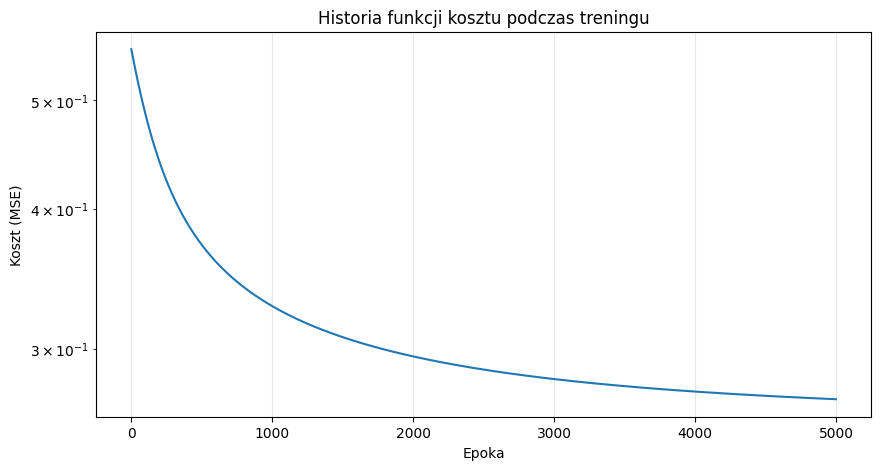

Koszt początkowy: 0.555173
Koszt końcowy: 0.270597


In [14]:
# wykres funkcji kosztu
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.xlabel('Epoka')
plt.ylabel('Koszt (MSE)')
plt.title('Historia funkcji kosztu podczas treningu')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

print(f"Koszt początkowy: {cost_history[0]:.6f}")
print(f"Koszt końcowy: {cost_history[-1]:.6f}")

## Ewaluacja sieci

In [15]:
# predykcja na danych treningowych
Y_pred_norm, _ = full_forward(X_train_norm, params, nn_architecture)

# denormalizacja predykcji
Y_pred = Y_pred_norm * Y_std + Y_mean

# obliczenie błędu
mse = np.mean((Y_pred - Y_train)**2)
mae = np.mean(np.abs(Y_pred - Y_train))

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {np.sqrt(mse):.6f}")

MSE: 0.001682
MAE: 0.032323
RMSE: 0.041010


## Porównanie predykcji z wartościami rzeczywistymi

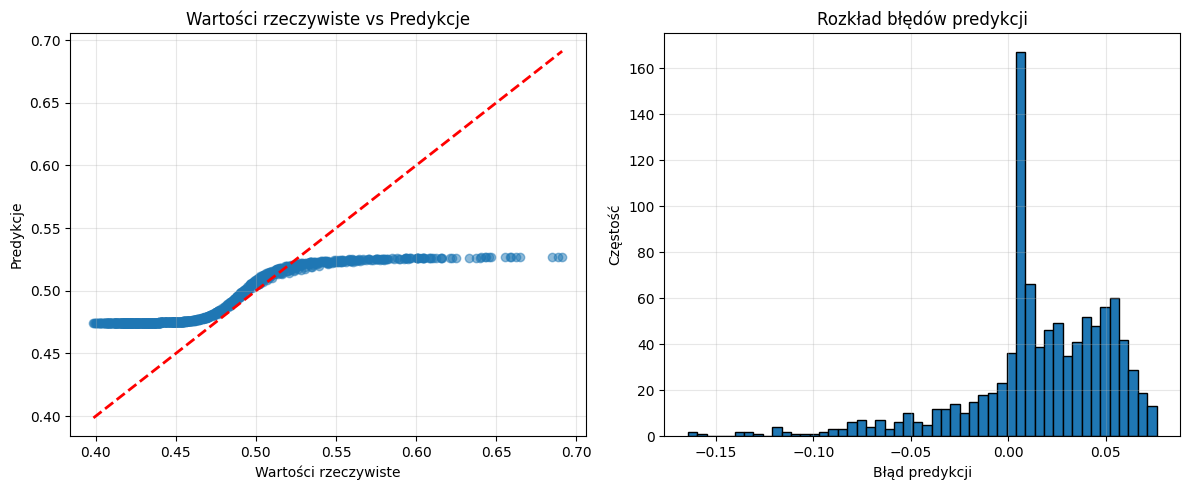

In [16]:
# wykres porównawczy
plt.figure(figsize=(12, 5))

# wykres scatter
plt.subplot(1, 2, 1)
plt.scatter(Y_train.flatten(), Y_pred.flatten(), alpha=0.5)
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'r--', lw=2)
plt.xlabel('Wartości rzeczywiste')
plt.ylabel('Predykcje')
plt.title('Wartości rzeczywiste vs Predykcje')
plt.grid(True, alpha=0.3)

# rozkład błędów
plt.subplot(1, 2, 2)
errors = (Y_pred - Y_train).flatten()
plt.hist(errors, bins=50, edgecolor='black')
plt.xlabel('Błąd predykcji')
plt.ylabel('Częstość')
plt.title('Rozkład błędów predykcji')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Wizualizacja 3D aproksymacji

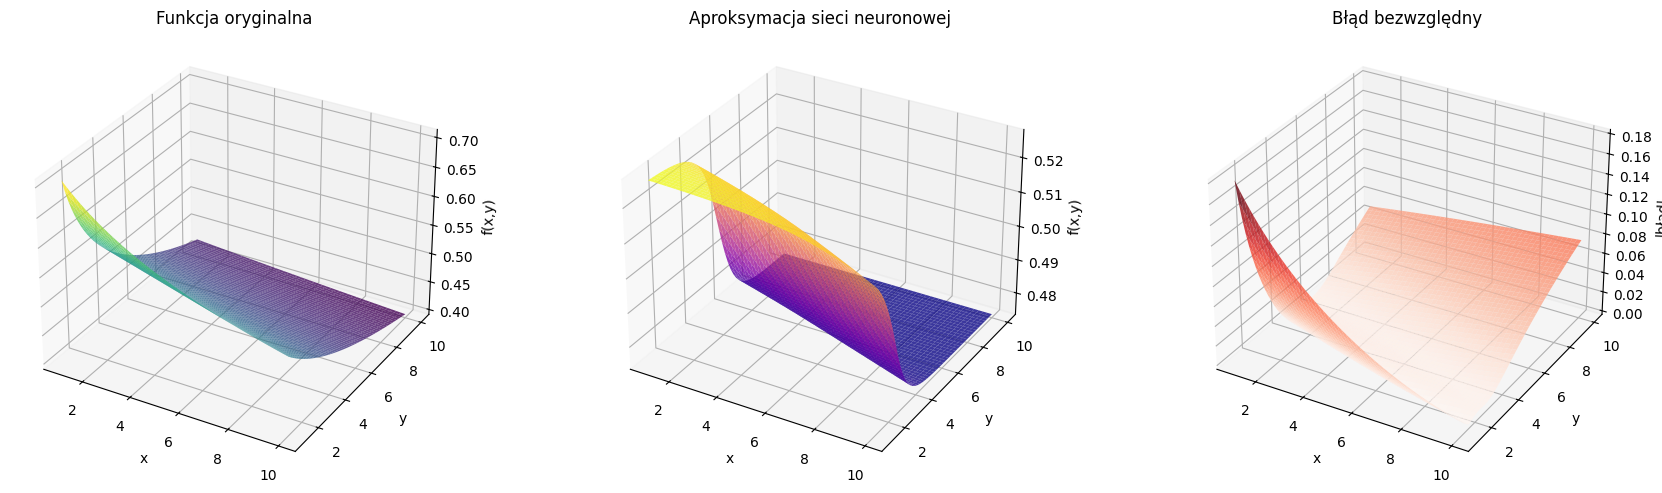

Maksymalny błąd bezwzględny: 0.180188
Średni błąd bezwzględny: 0.031597


In [17]:
# siatka testowa
x_test = np.linspace(1, 10, 50)
y_test = np.linspace(1, 10, 50)
X_mesh, Y_mesh = np.meshgrid(x_test, y_test)

# przygotowanie danych testowych
X_test = np.vstack([X_mesh.flatten(), Y_mesh.flatten()])
X_test_norm = (X_test - X_mean) / X_std

# predykcja
Z_pred_norm, _ = full_forward(X_test_norm, params, nn_architecture)
Z_pred = Z_pred_norm * Y_std + Y_mean
Z_pred_mesh = Z_pred.reshape(X_mesh.shape)

# wartości rzeczywiste
Z_true_mesh = target_function(X_mesh, Y_mesh)

# wizualizacja
fig = plt.figure(figsize=(18, 5))

# funkcja oryginalna
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X_mesh, Y_mesh, Z_true_mesh, cmap='viridis', alpha=0.8)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('f(x,y)')
ax1.set_title('Funkcja oryginalna')

# predykcja sieci
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X_mesh, Y_mesh, Z_pred_mesh, cmap='plasma', alpha=0.8)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('f(x,y)')
ax2.set_title('Aproksymacja sieci neuronowej')

# błąd
ax3 = fig.add_subplot(133, projection='3d')
error_mesh = np.abs(Z_true_mesh - Z_pred_mesh)
ax3.plot_surface(X_mesh, Y_mesh, error_mesh, cmap='Reds', alpha=0.8)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('|błąd|')
ax3.set_title('Błąd bezwzględny')

plt.tight_layout()
plt.show()

print(f"Maksymalny błąd bezwzględny: {error_mesh.max():.6f}")
print(f"Średni błąd bezwzględny: {error_mesh.mean():.6f}")

## Test na konkretnych punktach

In [18]:
# testowanie na konkretnych punktach
test_points = [
    (1, 1),
    (5, 5),
    (10, 10),
    (3, 7),
    (8, 2)
]

print("\nTest na wybranych punktach:")
print("="*70)
print(f"{'x':>6} {'y':>6} {'f(x,y) rzeczywista':>20} {'Predykcja':>15} {'Błąd':>10}")
print("="*70)

for x_val, y_val in test_points:
    # wartość rzeczywista
    z_true = target_function(x_val, y_val)
    
    # predykcja
    X_point = np.array([[x_val], [y_val]])
    X_point_norm = (X_point - X_mean) / X_std
    z_pred_norm, _ = full_forward(X_point_norm, params, nn_architecture)
    z_pred = z_pred_norm * Y_std + Y_mean
    
    error = abs(z_true - z_pred[0, 0])
    print(f"{x_val:6.1f} {y_val:6.1f} {z_true:20.6f} {z_pred[0,0]:15.6f} {error:10.6f}")


Test na wybranych punktach:
     x      y   f(x,y) rzeczywista       Predykcja       Błąd
   1.0    1.0             0.707107        0.526919   0.180188
   5.0    5.0             0.472871        0.481267   0.008396
  10.0   10.0             0.397635        0.474553   0.076917
   3.0    7.0             0.451801        0.475209   0.023408
   8.0    2.0             0.516973        0.515394   0.001579
